In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import rtbm.layers as layers
import rtbm.model as mdl

import warnings
warnings.filterwarnings('ignore')

from rtbm.costfunctions import mse, crossentropy
from rtbm import minimizer

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

from scipy import signal

# Example 1: Sine-Mixture with gaussian noise

In [2]:
def func(x,n):
    return 0.5*np.sin(1*x+0.1)+0.75*np.sin(0.25*x-0.3)+n*np.random.normal(0,0.2,x.shape[2])

X = np.linspace(0, 100, 500)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None],1).reshape((1,X.shape[1]))

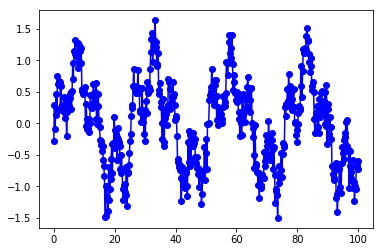

In [3]:
plt.plot(X.flatten(), Y.flatten(),"ob-")

In [4]:
M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(1,3,phase=1j))
M.add(layers.DiagExpectationUnitLayer(3,3,phase=1j))
M.add(layers.DiagExpectationUnitLayer(3,1,phase=1j))

In [5]:
minim = minimizer.CMA(parallel=True)
minim.train(mse, M, X, Y, tolfun=1e-4)

CMA on 32 cpu(s) enabled
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 29 (seed=233226, Sat Oct 28 18:48:38 2017)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 4.614735962679971e-01 1.0e+00 9.20e-01  9e-01  9e-01 0:00.3
    2     28 4.465431495843870e-01 1.1e+00 8.96e-01  9e-01  9e-01 0:00.6
    3     42 4.469255300572565e-01 1.1e+00 8.72e-01  9e-01  9e-01 0:00.8
   17    238 4.463552959565599e-01 1.5e+00 1.13e+00  1e+00  1e+00 0:03.9
   35    490 4.463680249974858e-01 1.7e+00 1.00e+00  9e-01  1e+00 0:07.9
   55    770 4.458722357611877e-01 1.8e+00 9.57e-01  8e-01  1e+00 0:13.0
   82   1148 4.448748234573606e-01 2.0e+00 8.65e-01  7e-01  9e-01 0:19.1
  100   1400 4.459294564022197e-01 2.1e+00 6.91e-01  6e-01  7e-01 0:23.2
  137   1918 4.445333981502925e-01 2.3e+00 7.49e-01  6e-01  8e-01 0:31.3
  177   2478 4.439970225739516e-01 2.4e+00 7.82e-01  7e-01  9e-01 0:40.5
  200   2800 4.427007331609157e-01 2.5e+00 5.40e-01  5e-01  6e-01 0:45.7
  248   

array([-1.02490012, -2.99817782,  0.57848148, -7.78296105, -0.24972904,
       -0.24940282,  9.70630144,  4.03703141,  3.86027661,  0.53078564,
       -3.19926681, -5.0964405 ,  3.16119284, -3.32214731,  1.66037195,
        3.23535514, -8.78977472, -9.63951892,  9.81298321, -8.20047241,
       -3.96423136,  4.34693536,  7.73292743,  1.96752403,  1.08407955,
        7.43223573, -7.93069066,  2.14465506,  1.78049686])

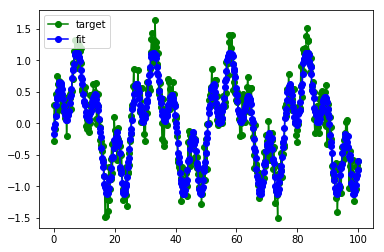

In [6]:
npoints = 500
test_X = (np.linspace(0, 100, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og-", label='target')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"ob-", label='fit')
plt.legend()

# Example 2: Sine-Cosine-Mixture with trend and gaussian noise

In [ ]:
def func(x,n):
    return 0.02*x+0.5*np.sin(1*x+0.1)+0.75*np.cos(0.25*x-0.3)+n*np.random.normal(0,0.2,x.shape[2])

X = np.linspace(0, 100, 500)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None],1).reshape((1,X.shape[1]))

In [ ]:
Y = func(X[:,None],0).reshape((1,X.shape[1]))

plt.plot(X.flatten(), Y.flatten(),"-")
plt.xlabel("t")
plt.ylabel("y")
plt.savefig("sincosmix.eps", format="eps")
plt.show()


In [ ]:
Y = func(X[:,None],1).reshape((1,X.shape[1]))

plt.plot(X.flatten(), Y.flatten(),"-")
plt.xlabel("t")
plt.ylabel("y")
plt.savefig("sincosmix_noise.eps", format="eps")

plt.show()



In [ ]:
M = mdl.Model()

M.add(layers.DiagExpectationUnitLayer(1,3))
M.add(layers.DiagExpectationUnitLayer(3,3))
M.add(layers.DiagExpectationUnitLayer(3,2))
M.add(layers.DiagExpectationUnitLayer(2,1))

In [ ]:
minim = minimizer.CMA(parallel=True)
minim.train(mse, M, X, Y, tolfun=1e-4)

In [ ]:
npoints = 500
test_X = (np.linspace(0, 100, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og", label='train')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"b-", label='fit', linewidth=5)
plt.legend()
plt.xlabel("t")
plt.ylabel("y")
plt.savefig("sincosmix_10-4.eps", format="eps")
plt.show()

# Example 3: Saw-tooth

In [ ]:
def func(x,n):
    return signal.sawtooth(x)

X = np.linspace(0, 30, 500)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None],1).reshape((1,X.shape[1]))

In [ ]:
plt.plot(X.flatten(), Y.flatten(),"ob-")

In [ ]:
M = mdl.Model()

M.add(layers.DiagExpectationUnitLayer(1,100))
minim = minimizer.CMA(parallel=True)
minim.train(mse, M, X, Y, maxiter=100)

In [ ]:
npoints = 500
test_X = (np.linspace(0, 30, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og-", label='target')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"ob-", label='fit')
plt.xaxis("t")
plt.yaxis("y(t)")
plt.savefig("sawtooth_reg.eps", format="eps")
plt.legend()

# Example 3: MNIST (work in progress...)

In [ ]:
# Load MNIST dataset
MNIST_train = pd.read_csv('~/data/mnist_train.csv', delimiter=",",header=None).values
MNIST_test  = pd.read_csv('~/data/mnist_test.csv', delimiter=",",header=None).values

# Prepare data (normalized onto [0,1])
Y_train = MNIST_train[0:100,0]
X_train = MNIST_train[0:100,1:]/255.0

Y_test = MNIST_test[:,0]
X_test = MNIST_test[:,1:]/255.0

In [ ]:
M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(784,10,Qmax=50,paramBound=100))
#M.add(layers.DiagExpectationUnitLayer(10,1))
M.add(layers.SoftMaxLayer(10))
#M.add(layers.MaxPosLayer(10,1))

enc = LabelBinarizer()
enc.fit(np.diag([1,1,1,1,1,1,1,1,1,1]))
enc.classes_ = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
T=enc.transform(Y_train)


In [ ]:
minim = minimizer.CMA(True)

sol=minim.train(crossentropy,M, np.transpose(X_train), np.transpose(Y_train), maxiter=250)

In [ ]:
sol

In [ ]:
P=np.argmax(np.real(M.predict(np.transpose(X_train))),axis=0)


print(classification_report(Y_train,P.T))
print(confusion_matrix(Y_train, P.T))

In [ ]:
P=np.argmax(np.real(M.predict(np.transpose(X_test))),axis=0)


print(classification_report(Y_test,P.T))
print(confusion_matrix(Y_test, P.T))